In [1]:
import sys, os
# path to TriplePandelReconstruction scripts
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections2")

# for GPU
# select which GPU to use
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# for CPU
# run JAX code on CPU
os.environ['JAX_PLATFORM']='cpu'

# jax stuff
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# TriplePandelReconstruction imports
from lib.simdata_i3 import I3SimHandler # data loading
from lib.gupta_network_eqx import get_network_eval_v_fn # network
from dom_track_eval import get_eval_network_doms_and_track # geometry evaluations

# and some pdf business
from lib.gupta import c_multi_gupta_spe_prob # gaussian convoluted SPE pdf
from lib.gupta import multi_gupta_pdf # original gupta mixture PDF
from lib.gupta import multi_gupta_cdf # original gupta mixture CDF

# other tools
import numpy as np
import matplotlib.pyplot as plt

dtype = jnp.float64

In [2]:
# path to TPN Reco
repo_path = '/home/storage/hans/jax_reco_gupta_corrections2/'

# path to one of the networks in the repo
network_path = os.path.join(repo_path, 'data/gupta/n96_w_penalty_1.e-3/new_model_no_penalties_tree_start_epoch_260.eqx')

# functions to evaluate relevant physics + network
eval_network_v = get_network_eval_v_fn(bpath=network_path, dtype=dtype, n_hidden=96)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype, gupta=True)

In [3]:
# load some event
event_id = '20027'

# location of .ftr files
bp = '/home/storage2/hans/i3files/alerts/bfrv2_no_hole_ice_flat/ftr/charge/calibrated/'
sim_handler = I3SimHandler(os.path.join(bp, f'meta_ds_event_{event_id}_N100_from_0_to_10_1st_pulse.ftr'),
                os.path.join(bp, f'pulses_ds_event_{event_id}_N100_from_0_to_10_1st_pulse.ftr'),
                os.path.join(repo_path, 'data/icecube/detector_geometry.csv')
            )

In [4]:
# get data from first event (all pulses)
index = 0
meta, pulses = sim_handler.get_event_data(index)

# create pandas table of summary values for reconstruction.
# time of first hit, total charge, x, y, z etc.
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

# and fix early pulses
sim_handler.replace_early_pulse(event_data, pulses)

In [5]:
# for illustration, we look at the summary data of the brightest DOM.
ix = event_data['charge'].argmax()
print(event_data.loc[ix, ['sensor_id', 'charge', 'x', 'y', 'z', 'time']])

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']
print("")

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")

sensor_id      916.00000
charge        6305.47301
x             -166.40000
y             -287.79000
z              225.20000
time         12654.00000
Name: 164, dtype: float64

selected DOM is located on IceCube string 16 and is number 17.


In [6]:
# let's get all pulses for this DOM (and not just the 1st one)
sensor_selection = pulses['sensor_id'] == brightest_sensor_id
pulses_this_dom = pulses[sensor_selection]

print(f"selected DOM has recorded {len(pulses_this_dom)} pulses.")

selected DOM has recorded 128 pulses.


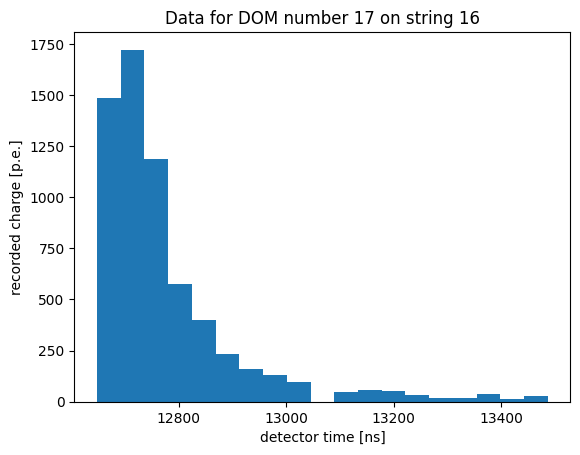

In [16]:
# let's visualize pulses
min_time = pulses_this_dom['time'].min()
max_time = pulses_this_dom['time'].max()
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'], bins=time_bins, weights=pulses_this_dom['charge'])
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("detector time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [8]:
# The detector time is not very interesting. 
# Let's convert to delay_time, the time relative to the 
# expected arrival time of an unscattered photon.

# This requires information about the muon.
# Here we use true values, but in practice one would work with the seed parameters.
track_time = jnp.array(meta['muon_time'])
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_dir = jnp.array([meta['muon_zenith'], meta['muon_azimuth']])

print(f"At time {track_time:.1f} ns: the track is at position ("
      f"X={track_pos[0]:.1f}m, "
      f"Y={track_pos[1]:.1f}m, "
      f"z={track_pos[2]:.1f}m"
      f").")

At time 823.1 ns: the track is at position (X=2053.1m, Y=2454.7m, z=103.1m).


In [9]:
# While, for this notebook, we are currently interested in only one DOM, 
# let's do the compuation for all DOMs at once and then select the values 
# for the selected DOM. This is what one would do in practice.

dom_pos = event_data[['x', 'y', 'z']].values
print("N_DOMs x 3 = ", dom_pos.shape)
print("coordinates of selected DOM (in meters):", dom_pos[ix])

# gupta parameters + geo_time
logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, track_pos, track_dir)
print("shape of logits: ", logits.shape)
print("shape of geo_time: ", geo_time.shape)

logits_this_dom = logits[ix]
a_this_dom = logits[ix]
b_this_dom = bv[ix]
geo_time_this_dom = geo_time[ix]
print(f"geo_time of selected DOM: {geo_time_this_dom:.1f}ns.")

# network output in logits need one conversion step
# (from logit to actual probabilities)
mix_probs = jax.nn.softmax(logits, axis=1)
mix_probs_this_dom = mix_probs[ix]

print("mixing probabilities for selected DOM: ", mix_probs_this_dom)

N_DOMs x 3 =  (727, 3)
coordinates of selected DOM (in meters): [-166.4  -287.79  225.2 ]
shape of logits:  (727, 3)
shape of geo_time:  (727,)
geo_time of selected DOM: 11826.7ns.
mixing probabilities for selected DOM:  [0.44959644 0.34003659 0.21036697]


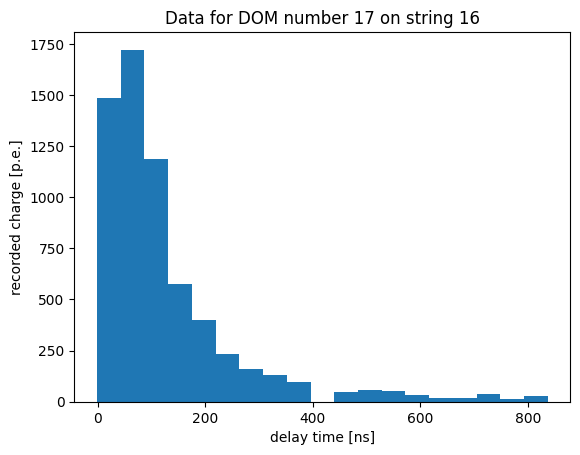

In [17]:
# let's visualize pulses in correct time units (delay time)
time_offset = track_time + geo_time_this_dom

min_time = pulses_this_dom['time'].min() - time_offset
max_time = pulses_this_dom['time'].max() - time_offset
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'] - time_offset, bins=time_bins, weights=pulses_this_dom['charge'])
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("delay time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [11]:
# let's evaluate some PDFs and CDFs.
some_time = 10. # ns

# original pdf:
print(multi_gupta_pdf(some_time, mix_probs_this_dom, a_this_dom, b_this_dom))

# original cdf (will go into KS-test):
print(multi_gupta_cdf(some_time, mix_probs_this_dom, a_this_dom, b_this_dom))

# convoluted pdf (with 3ns smearing. This is what's in the reco.):
print(c_multi_gupta_spe_prob(some_time, mix_probs_this_dom, a_this_dom, b_this_dom, 3.0))

0.025742221473507014
0.23600399422325258
0.025020615803244516


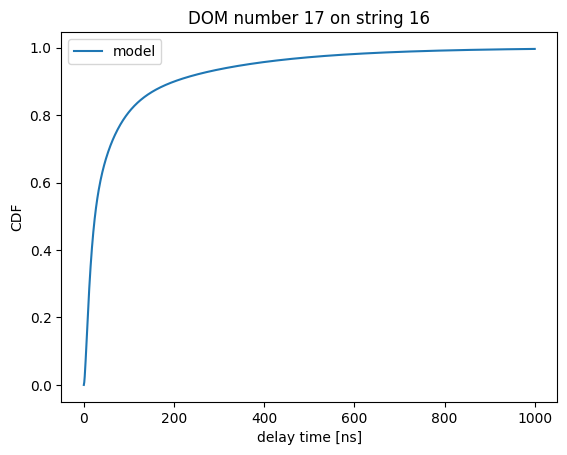

In [18]:
# let's plot the CDF
xvals = jnp.linspace(0.0, 1000, 1000)

# Rather than looping over all pulses, we simply vectorize the cdf function
# over the time argument.

multi_gupta_cdf_v = jax.vmap(multi_gupta_cdf, (0, None, None, None), 0)
cdf_values = multi_gupta_cdf_v(xvals, mix_probs_this_dom, a_this_dom, b_this_dom)

plt.figure()
plt.plot(xvals, cdf_values, label="model")
plt.xlabel("delay time [ns]")
plt.ylabel("CDF")
plt.legend()
plt.title(f"DOM number {om} on string {string}")
plt.show()

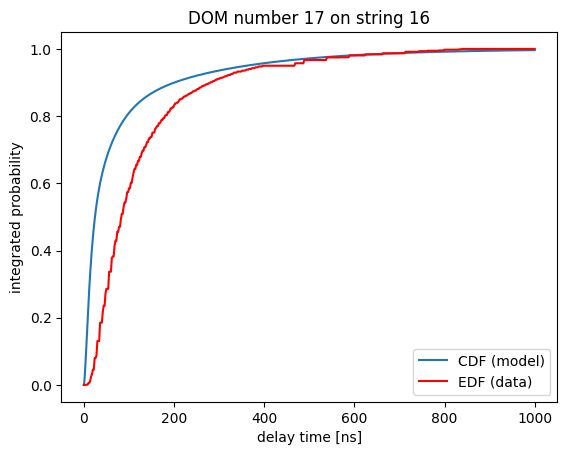

In [19]:
# can compare this to the data

pulse_times = pulses_this_dom['time'].values - time_offset

# for our comparison, we can not deal with negative times, because we
# work with the unconvoluted CDF. For this it is safe to pretend that 
# negative times are piled up at 0
pulse_times = np.where(pulse_times < 0.0, 0.0, pulse_times)

pulse_charges = pulses_this_dom['charge'].values
total_charge = np.sum(pulse_charges)

# compute the EDF values in a single loop.
# Remember: EDF ~ integration until upper edge.
time_bins = np.linspace(0.0, 1000.0, 500)
edf_vals = [0] * (len(time_bins)-1)
integrated_charge= 0
pulse_idx = 0
for i in range(len(edf_vals)):
    # integrate pulses below bin's upper edge
    while pulse_idx < len(pulse_times) and pulse_times[pulse_idx] < time_bins[i+1]:
        integrated_charge += pulse_charges[pulse_idx]
        pulse_idx += 1
        
    edf_vals[i] = integrated_charge / total_charge

edf_vals = np.array(edf_vals)
# EDF is 0 at time = 0.
insert_index = 0
edf_vals = np.insert(edf_vals, insert_index, 0.0)

plt.figure()
plt.plot(xvals, cdf_values, label="CDF (model)")
plt.plot(time_bins, edf_vals, 'r-', label='EDF (data)')
plt.xlabel("delay time [ns]")
plt.ylabel("integrated probability")
plt.title(f"DOM number {om} on string {string}")
plt.legend()
plt.show()

In [14]:
# and just the one line example how to evaluate the model CDF 
# on the pulse times:

print(multi_gupta_cdf_v(pulse_times, mix_probs_this_dom, a_this_dom, b_this_dom))

[0.         0.07778593 0.21543891 0.24146188 0.29032694 0.35503157
 0.39256125 0.42599093 0.46938679 0.52726809 0.53710749 0.58715857
 0.59427759 0.63166604 0.63716106 0.66221221 0.66680123 0.69196561
 0.69581333 0.71718117 0.72048415 0.7360361  0.74184325 0.75281948
 0.76053574 0.77019592 0.77700534 0.78554955 0.78960689 0.79544116
 0.80098977 0.80797327 0.81292056 0.81915784 0.82358419 0.82780901
 0.8331491  0.83817823 0.84176062 0.8463025  0.84954435 0.85265427
 0.85660882 0.85943996 0.86304769 0.86563611 0.86894167 0.86974337
 0.87361289 0.87582964 0.87726643 0.88004692 0.88205526 0.88400153
 0.88650568 0.88831961 0.89008172 0.89235515 0.89400639 0.89561403
 0.89769343 0.89920746 0.90068452 0.90259942 0.90399677 0.90536251
 0.90713672 0.90843396 0.90970392 0.91135668 0.91256723 0.91375399
 0.91530092 0.91643567 0.91754948 0.9190033  0.92007113 0.92112036
 0.92249148 0.92349967 0.9244912  0.9257882  0.92674278 0.9276823
 0.92891229 0.92981826 0.93071051 0.93187942 0.93274099 0.93358